In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns

In [2]:
def plotCNNPerformanceMetrics(performance_file, scenario="all"):
    #performance_file = "../../results/opt-cnn-performance-metrics-summary-" + str(resolution) + "px.csv"
#     resolution = performance_file.split('-')[-1].split('px')[0]
    resolution = performance_file.split('-')[-10].split('px')[0]
    co = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]
    if 'test' in performance_file:
        model_name = performance_file.split('-')[-15].split('px')[0]
    else:
        model_name = performance_file.split('-')[-13].split('px')[0]
    print(model_name)
    dfm = pd.read_csv(performance_file)
    num_epochs = dfm.epoch.max()
    #melted_df = dfm.melt(id_vars = ["epoch", "Scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy"], var_name = "metric", value_name = "value")
    melted_df = dfm.melt(id_vars = ["epoch", "Scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy", "val_f1", "val_precision", "val_recall"], var_name = "metric", value_name = "value")
    melted_df["metric_type"] = None
    melted_df["phase"] = "Validation"
    melted_df.loc[melted_df.metric.isin(["loss", "val_loss"]), "metric_type"] = "Loss"
    melted_df.loc[melted_df.metric.isin(["accuracy", "val_accuracy", "val_f1", "val_precision", "val_recall"]), "metric_type"] = "Performance"
    melted_df.loc[melted_df.metric.isin(["loss", "accuracy"]), "phase"] = "Training"
    #print(melted_df.metric.unique())
#     if not scenario=="all":
#         melted_df = melted_df.loc[melted_df.Scenario==scenario]
    
    sns.set_style("whitegrid")
    if not scenario=="all":
        g = sns.FacetGrid(melted_df, col="Scenario", row="metric_type", sharey = False, hue_kws = {"linestyle" : ["-","--"]})
    else:
        g = sns.FacetGrid(melted_df, col="Scenario", row="metric_type", col_order = co, sharey = False, hue_kws = {"linestyle" : ["-","--"]})
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", ci=None, hue = "metric", style="phase",  style_order=["Validation", "Training"], alpha=.85,
                    #palette= sns.color_palette("Set2", n_colors=8) 
                   )
    g.set_axis_labels("Epoch", "", fontsize = 16)
    g.add_legend(bbox_to_anchor=(1.02, .75), loc=2,fontsize=16) 
    ## Customize legend
    g._legend.texts[0].set_text("")
    g._legend.texts[1].set_text("Train. loss") #Data
    g._legend.texts[2].set_text("Test loss")
    g._legend.texts[3].set_text("")    
    g._legend.texts[4].set_text("")    
    g._legend.texts[5].set_text("")    
    g._legend.texts[6].set_text("Train. accuracy")    
    g._legend.texts[7].set_text("Test accuracy")    
    g._legend.texts[8].set_text("Avg. F1")    
    g._legend.texts[9].set_text("Avg. precision")    
    g._legend.texts[10].set_text("Avg. recall")    
    g._legend.legendHandles[4].set_linewidth(0)
    g._legend.legendHandles[5].set_linewidth(0)    
    g._legend.legendHandles[6].set_linestyle('--')    
    g._legend.legendHandles[1].set_linestyle('--')    

    # g._legend._legend_box.sep = 5
    axes = g.axes
    for row, axlist in enumerate(axes):
        if row==0:
            for col, axis in enumerate(axes[row]):
                print("base model ylimit set")
                axes[row, col].set_ylim(-0.05, 5)#.75                 
                if not('base') in model_name:
                    axes[row, col].set_ylim(0, 5)
                else: 
                    pass# print("base model ylimit set")
                    #axes[row, col].set_ylim(-0.05, 4)#.75 
                if 'base' not in model_name:
                    axes[row, col].set_xlim(1, num_epochs)
                else: #'base' in model_name:
                    if num_epochs % 3 == 0:
                        majors = []
                        for i in range(1,num_epochs+1,2):
                            majors.append(i)
                        axes[row, col].xaxis.set_major_locator(tkr.FixedLocator(majors))
                    elif num_epochs % 2 == 0:
                        axes[row, col].xaxis.set_major_locator(tkr.MultipleLocator(2))
                    else:
                        majors = []
                        for i in range(1,num_epochs+1):
                            majors.append(i)
                        axes[row, col].xaxis.set_major_locator(tkr.FixedLocator(majors))
                axes[row, col].set_title("Scenario: " + str(axes[row, col].title).split("Scenario = ")[1].split(")")[0].split("\'")[0],
                                        fontsize=16)
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Loss", fontsize=16)
        elif row==1:
            for col, axis in enumerate(axes[row]):
                #axes[row, col].set_xlim(0, 1.05)
                axes[row, col].set_ylim(0, 1.05)
                if not("base") in model_name:
                    axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].set_title("")
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Performance", fontsize=16)
    g.fig.tight_layout()
    if scenario != "all":
        g.savefig("../../figures/" + model_name + "-" + scenario + "-performance-metrics-" + str(resolution) + "px-plot.png", dpi=180)
    else:
        g.savefig("../../figures/" + model_name + "-performance-metrics-" + str(resolution) + "px-plot.png", dpi=180)
    return(dfm)

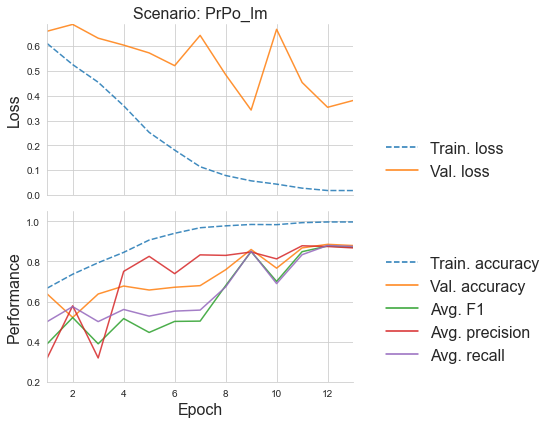

In [3]:
PERFORMANCE_FILE  = "../../results/opt-cnn-performance-metrics-summary-128px.csv"
d = plotCNNPerformanceMetrics(PERFORMANCE_FILE)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,1.543852,0.642857,0.654235,0.669173,0.400901,0.500000,0.334586,PrPo_Im,1
1,1,0.784658,0.669173,0.634400,0.669173,0.400901,0.500000,0.334586,PrPo_Im,2
2,2,0.752994,0.627820,171.794434,0.669173,0.400901,0.500000,0.334586,PrPo_Im,3
3,3,0.791354,0.675752,137.696777,0.330827,0.248588,0.500000,0.165414,PrPo_Im,4
4,4,0.741272,0.646617,557.390808,0.669173,0.400901,0.500000,0.334586,PrPo_Im,5
...,...,...,...,...,...,...,...,...,...,...
195,195,0.549163,0.782895,3.972593,0.661654,0.265460,0.329588,0.222222,Pr_Po_Im,46
196,196,0.486690,0.803571,1.894289,0.661654,0.357849,0.371587,0.479024,Pr_Po_Im,47
197,197,0.488968,0.800752,2.035661,0.541353,0.344218,0.361679,0.360812,Pr_Po_Im,48
198,198,0.415347,0.835526,2.530274,0.669173,0.322492,0.357182,0.669251,Pr_Po_Im,49


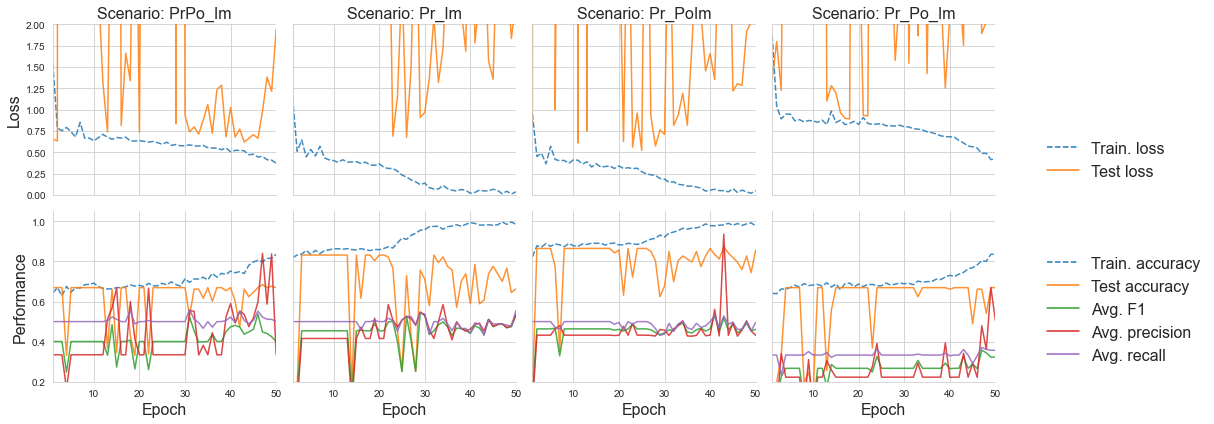

In [19]:
RESNET_PERFORMANCE_TESTING_MODE  = "../../results/test-opt-cnn-performance-metrics-summary-resnet50-w-252-px-h252-px-03-Aug-2021-16-17-45.csv"
plotCNNPerformanceMetrics(RESNET_PERFORMANCE_TESTING_MODE)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.576029,0.800234,5.734849,0.831776,0.454082,0.500000,0.415888,Pr_Im,1
1,1,0.481418,0.836449,4.290155,0.831776,0.454082,0.500000,0.415888,Pr_Im,2
2,2,0.450905,0.850467,0.472767,0.803738,0.623807,0.616105,0.634783,Pr_Im,3
3,3,0.435029,0.842290,1.538803,0.831776,0.454082,0.500000,0.415888,Pr_Im,4
4,4,0.396904,0.843458,1.093681,0.467290,0.443776,0.591136,0.554478,Pr_Im,5
5,5,0.398808,0.857477,0.777197,0.831776,0.454082,0.500000,0.415888,Pr_Im,6
6,6,0.383682,0.853972,0.831945,0.831776,0.454082,0.500000,0.415888,Pr_Im,7
7,7,0.342482,0.858645,1.669446,0.831776,0.454082,0.500000,0.415888,Pr_Im,8
8,8,0.334808,0.858645,0.903521,0.831776,0.454082,0.500000,0.415888,Pr_Im,9
9,9,0.303007,0.872664,1.340428,0.831776,0.454082,0.500000,0.415888,Pr_Im,10


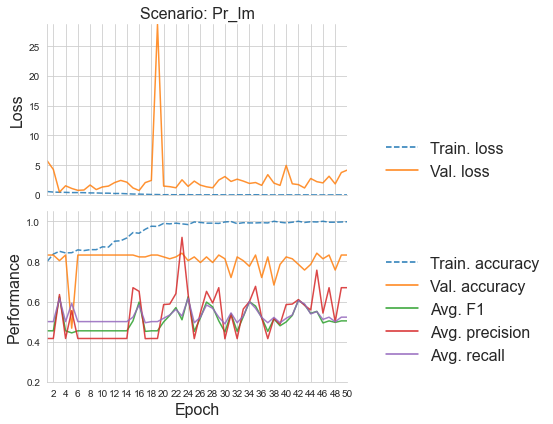

In [13]:
BASE_PERFORMANCE_TESTING_MODE_NON_OPT  = "../../results/test-opt-cnn-performance-metrics-summary-base-w-252-px-h252-px-03-Aug-2021-11-34-24.csv"
plotCNNPerformanceMetrics(BASE_PERFORMANCE_TESTING_MODE_NON_OPT)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.780720,0.638158,6.312048,0.669173,0.400901,0.500000,0.334586,PrPo_Im,1
1,1,0.676411,0.661654,21.682978,0.669173,0.400901,0.500000,0.334586,PrPo_Im,2
2,2,0.610713,0.675752,3.918718,0.676692,0.424937,0.511364,0.837121,PrPo_Im,3
3,3,0.614819,0.686090,3.773045,0.669173,0.400901,0.500000,0.334586,PrPo_Im,4
4,4,0.596154,0.707707,2.877229,0.669173,0.400901,0.500000,0.334586,PrPo_Im,5
5,5,0.593588,0.681391,1.272687,0.669173,0.400901,0.500000,0.334586,PrPo_Im,6
6,6,0.585714,0.686090,2.928554,0.669173,0.400901,0.500000,0.334586,PrPo_Im,7
7,7,0.573273,0.702068,0.930102,0.631579,0.537441,0.540858,0.553050,PrPo_Im,8
8,8,0.563468,0.716165,2.526623,0.669173,0.400901,0.500000,0.334586,PrPo_Im,9
9,9,0.528047,0.734962,1.160329,0.669173,0.400901,0.500000,0.334586,PrPo_Im,10


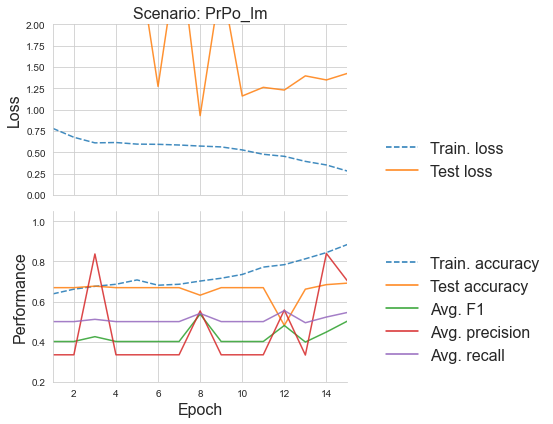

In [34]:
BASE_PERFORMANCE_TESTING_MODE_NON_OPT  = "../../results/test-opt-cnn-performance-metrics-summary-base-w-252-px-h252-px-06-Aug-2021-05-16-25.csv"
plotCNNPerformanceMetrics(BASE_PERFORMANCE_TESTING_MODE_NON_OPT)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.970355,0.665414,0.717819,0.330827,0.248588,0.500000,0.165414,PrPo_Im,1
1,1,0.671890,0.680451,1.029241,0.669173,0.400901,0.500000,0.334586,PrPo_Im,2
2,2,0.672813,0.676692,4.844982,0.330827,0.248588,0.500000,0.165414,PrPo_Im,3
3,3,0.632192,0.681391,498.461456,0.330827,0.248588,0.500000,0.165414,PrPo_Im,4
4,4,0.688452,0.671053,325.482635,0.330827,0.248588,0.500000,0.165414,PrPo_Im,5
...,...,...,...,...,...,...,...,...,...,...
195,195,0.791611,0.697368,1.787463,0.669173,0.267267,0.333333,0.223058,Pr_Po_Im,46
196,196,0.793605,0.689850,1.173070,0.593985,0.293821,0.323106,0.275845,Pr_Po_Im,47
197,197,0.789091,0.681391,1.001484,0.639098,0.259939,0.318352,0.219638,Pr_Po_Im,48
198,198,0.780767,0.691729,1.119761,0.669173,0.267267,0.333333,0.223058,Pr_Po_Im,49


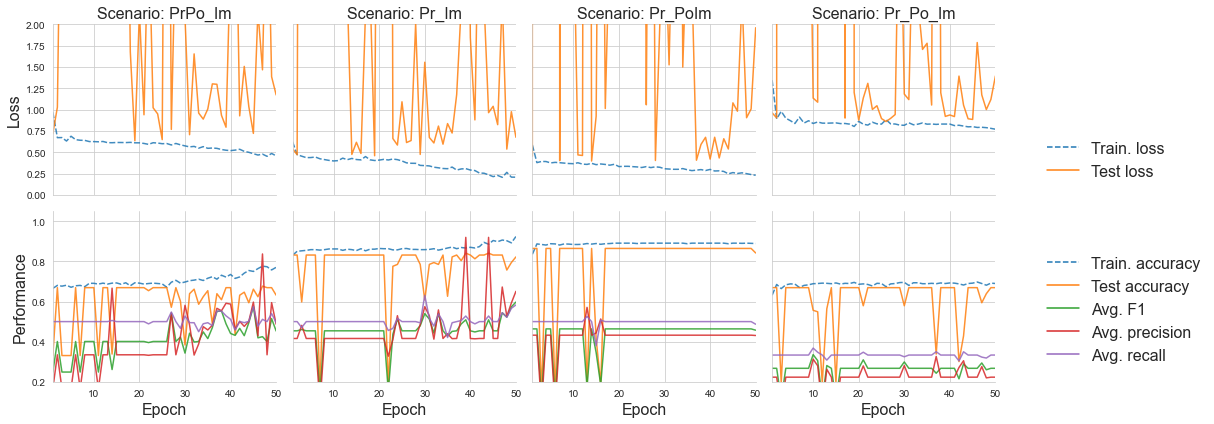

In [30]:
INCEPTION_TESTING_MODE  = "../../results/test-opt-cnn-performance-metrics-summary-inception_v3-w-252-px-h252-px-04-Aug-2021-21-20-17.csv"
plotCNNPerformanceMetrics(INCEPTION_TESTING_MODE)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,1.543852,0.642857,0.654235,0.669173,0.400901,0.500000,0.334586,PrPo_Im,1
1,1,0.784658,0.669173,0.634400,0.669173,0.400901,0.500000,0.334586,PrPo_Im,2
2,2,0.752994,0.627820,171.794434,0.669173,0.400901,0.500000,0.334586,PrPo_Im,3
3,3,0.791354,0.675752,137.696777,0.330827,0.248588,0.500000,0.165414,PrPo_Im,4
4,4,0.741272,0.646617,557.390808,0.669173,0.400901,0.500000,0.334586,PrPo_Im,5
...,...,...,...,...,...,...,...,...,...,...
195,195,0.549163,0.782895,3.972593,0.661654,0.265460,0.329588,0.222222,Pr_Po_Im,46
196,196,0.486690,0.803571,1.894289,0.661654,0.357849,0.371587,0.479024,Pr_Po_Im,47
197,197,0.488968,0.800752,2.035661,0.541353,0.344218,0.361679,0.360812,Pr_Po_Im,48
198,198,0.415347,0.835526,2.530274,0.669173,0.322492,0.357182,0.669251,Pr_Po_Im,49


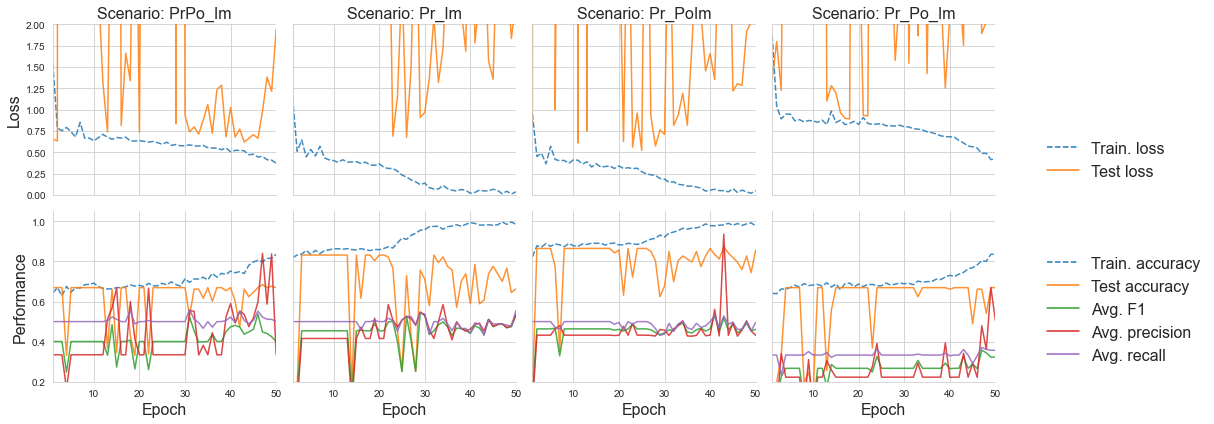

In [31]:
RESNET_TESTING_MODE  = "../../results/test-opt-cnn-performance-metrics-summary-resnet50-w-252-px-h252-px-03-Aug-2021-16-17-45.csv"
plotCNNPerformanceMetrics(RESNET_TESTING_MODE)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,1.097863,0.649436,0.665594,0.669173,0.400901,0.5,0.334586,PrPo_Im,1
1,1,0.697754,0.656015,731.679504,0.330827,0.248588,0.5,0.165414,PrPo_Im,2
2,2,0.682798,0.675752,48.968445,0.669173,0.400901,0.5,0.334586,PrPo_Im,3
3,3,0.684195,0.668233,1068.964966,0.669173,0.400901,0.5,0.334586,PrPo_Im,4
4,4,0.678964,0.676692,5.459500,0.669173,0.400901,0.5,0.334586,PrPo_Im,5
5,5,0.655051,0.671053,163.302261,0.669173,0.400901,0.5,0.334586,PrPo_Im,6
6,6,0.659202,0.679511,131.188263,0.330827,0.248588,0.5,0.165414,PrPo_Im,7
7,7,0.627172,0.687030,0.651478,0.669173,0.400901,0.5,0.334586,PrPo_Im,8
8,8,0.665630,0.658835,0.666822,0.669173,0.400901,0.5,0.334586,PrPo_Im,9
9,9,0.646361,0.684211,0.676685,0.669173,0.400901,0.5,0.334586,PrPo_Im,10


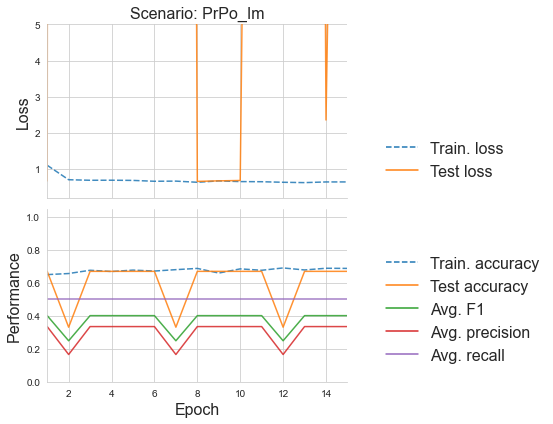

In [40]:
INCEPTION_PATIENCE_7_TESTING_MODE  = "../../results/test-opt-cnn-performance-metrics-summary-inception_v3-w-252-px-h252-px-patience-7-12-Aug-2021-18-43-18.csv"
plotCNNPerformanceMetrics(INCEPTION_PATIENCE_7_TESTING_MODE)

base model ylimit set


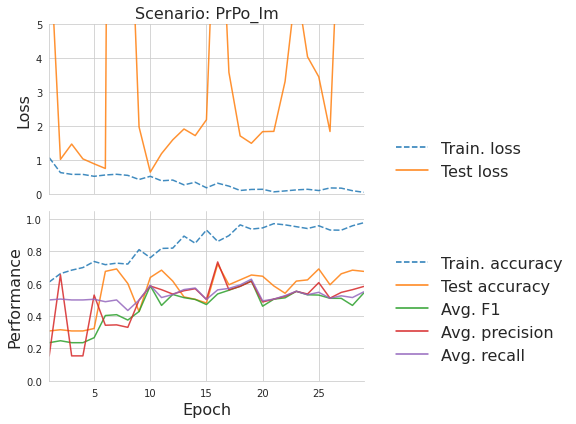

In [53]:
#RESNET_PATIENCE_7_TESTING_MODE  = "../../results/test-opt-cnn-performance-metrics-summary-resnet50-w-252-px-h252-px-patience-7-12-Aug-2021-16-55-48.csv"
RESNET_PATIENCE_10  = "../../results/opt-cnn-performance-metrics-summary-resnet50-w-336-px-h336-20-Aug-2021-05-31-07-px.csv"
#plotCNNPerformanceMetrics(RESNET_PATIENCE_7_TESTING_MODE)
gg = plotCNNPerformanceMetrics(RESNET_PATIENCE_10, scenario = "Pr_Im")

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,1.045355,0.597744,9.548343,0.669173,0.400901,0.500000,0.334586,PrPo_Im,1
1,1,0.697163,0.649436,3.841085,0.669173,0.400901,0.500000,0.334586,PrPo_Im,2
2,2,0.669132,0.649436,1.687887,0.676692,0.424937,0.511364,0.837121,PrPo_Im,3
3,3,0.666787,0.662594,0.934418,0.669173,0.421739,0.505746,0.585878,PrPo_Im,4
4,4,0.594769,0.693609,1.306892,0.676692,0.424937,0.511364,0.837121,PrPo_Im,5
...,...,...,...,...,...,...,...,...,...,...
56,56,0.039458,0.995301,0.915591,0.646617,0.261796,0.322097,0.220513,Pr_Po_Im,10
57,57,0.026857,0.994361,0.932426,0.639098,0.329831,0.351276,0.416667,Pr_Po_Im,11
58,58,0.022854,0.997180,1.202369,0.661654,0.266667,0.329588,0.223919,Pr_Po_Im,12
59,59,0.030378,0.993421,1.026827,0.571429,0.318527,0.339095,0.300611,Pr_Po_Im,13


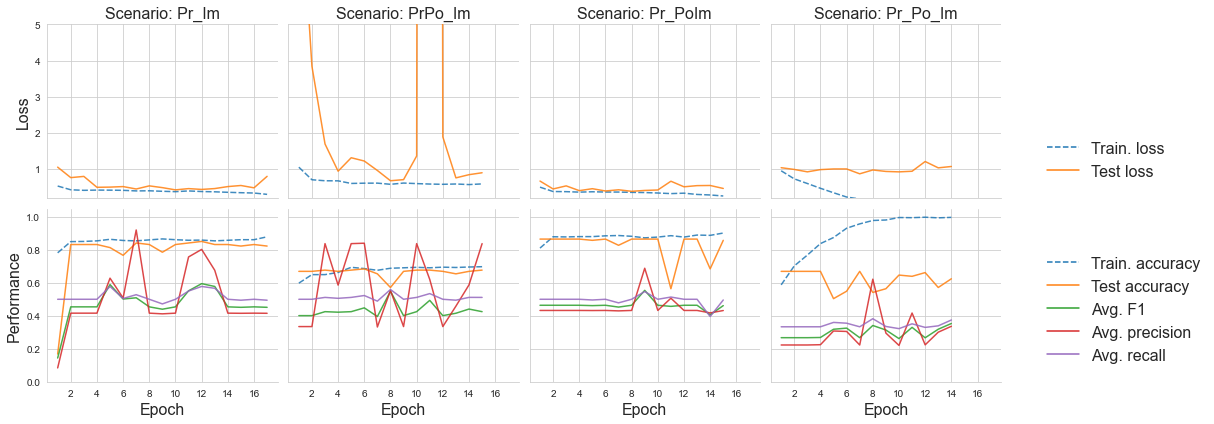

In [3]:
OPT_BASE_7_TESTING_MODE  = "../../results/opt-cnn-performance-metrics-summary-base-w-252-px-h252-16-Aug-2021-20-52-44-px.csv"
plotCNNPerformanceMetrics(OPT_BASE_7_TESTING_MODE)

base model ylimit set
base model ylimit set
base model ylimit set
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.740773,0.544496,0.599490,0.851852,0.460000,0.500000,0.425926,Pr_Im,1
1,1,0.606847,0.677986,0.601273,0.851852,0.460000,0.500000,0.425926,Pr_Im,2
2,2,0.550174,0.724824,0.474556,0.851852,0.460000,0.500000,0.425926,Pr_Im,3
3,3,0.449907,0.826698,0.417567,0.851852,0.460000,0.500000,0.425926,Pr_Im,4
4,4,0.365429,0.861827,0.442166,0.851852,0.460000,0.500000,0.425926,Pr_Im,5
...,...,...,...,...,...,...,...,...,...,...
82,82,0.054212,0.979323,2.848562,0.676692,0.270270,0.326087,0.230769,Pr_Po_Im,20
83,83,0.057915,0.982143,4.503946,0.691729,0.272593,0.333333,0.230576,Pr_Po_Im,21
84,84,0.025375,0.990601,2.206462,0.639098,0.359543,0.385652,0.337459,Pr_Po_Im,22
85,85,0.013334,0.997180,2.135872,0.669173,0.350532,0.371014,0.345546,Pr_Po_Im,23


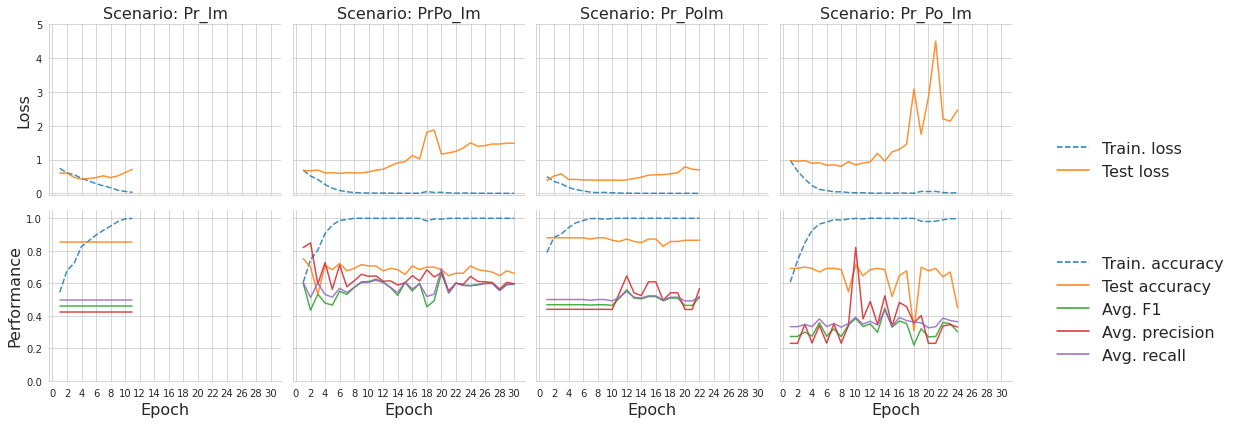

In [51]:
OPT_BASE_10  = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h336-19-Aug-2021-16-40-02-px.csv"
plotCNNPerformanceMetrics(OPT_BASE_10)

base model ylimit set


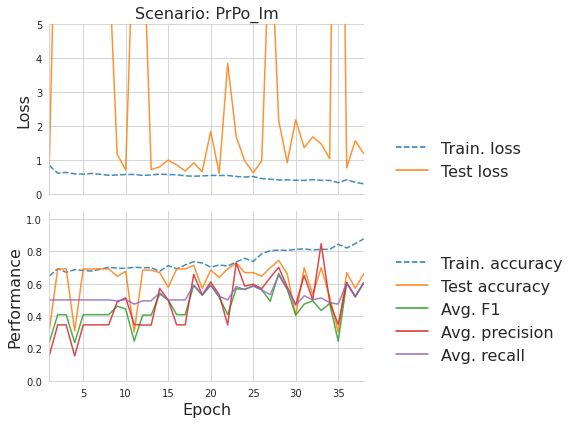

In [58]:
#RESNET_PATIENCE_7_TESTING_MODE  = "../../results/test-opt-cnn-performance-metrics-summary-resnet50-w-252-px-h252-px-patience-7-12-Aug-2021-16-55-48.csv"
INCEPTION_PATIENCE_10  = "../../results/opt-cnn-performance-metrics-summary-inception_v3-w-336-px-h336-21-Aug-2021-12-46-16-px.csv"
gg = plotCNNPerformanceMetrics(INCEPTION_PATIENCE_10, scenario = "PrPo_Im")

## 6 layer architecture, test set size=0.25, occlusion=0.3, pixel_level=True

In [67]:
results = {"../../results/opt-cnn-performance-metrics-summary-base-a-w-336-px-h336-08-Feb-2022-09-54-07-px.csv":"Pr_Im", 
           "../../results/opt-cnn-performance-metrics-summary-base-a-w-336-px-h336-08-Feb-2022-11-33-46-px.csv":"PrPo_Im", 
           "../../results/opt-cnn-performance-metrics-summary-base-a-w-336-px-h336-08-Feb-2022-14-12-11-px.csv":"Pr_PoIm", 
           "../../results/opt-cnn-performance-metrics-summary-base-a-w-336-px-h336-08-Feb-2022-15-59-22-px.csv":"Pr_Po_Im"}

base
base model ylimit set
base
base model ylimit set
base
base model ylimit set
base
base model ylimit set


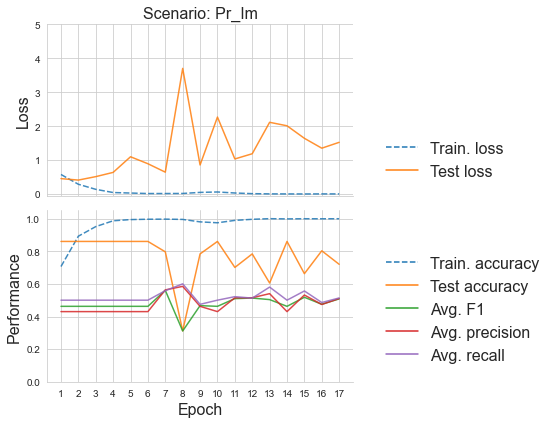

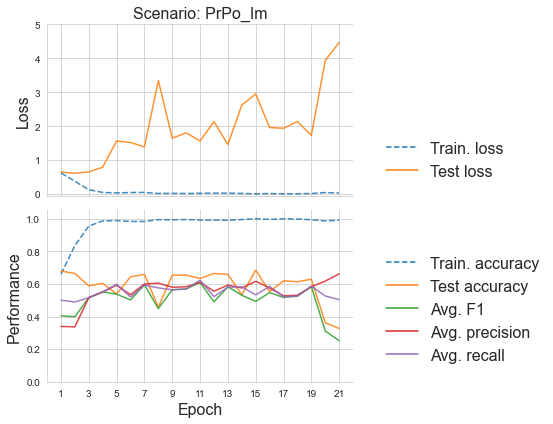

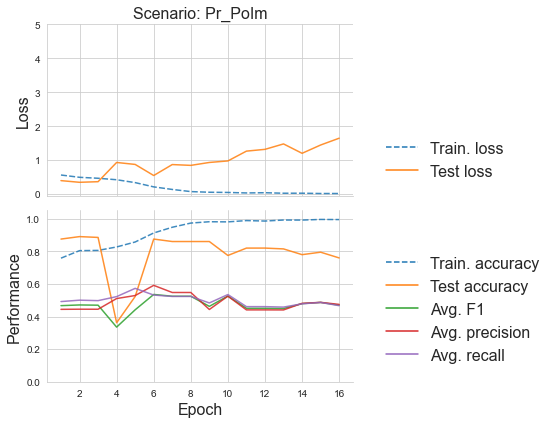

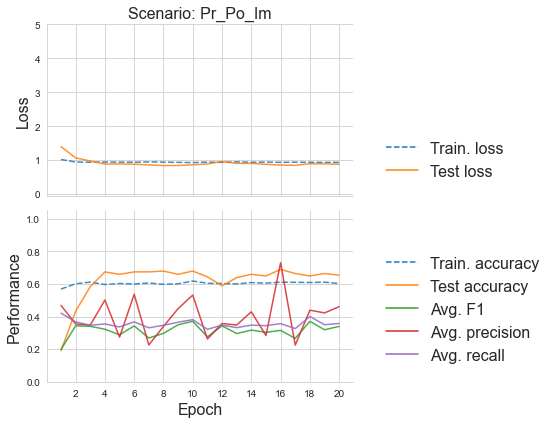

In [72]:
for r,s in results.items():
    plotCNNPerformanceMetrics(r,s)

### 5-layer architecture, test set size=0.25, occlusion=0.3, pixel_level=True

summary
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.606742,0.669205,0.619910,0.678392,0.404192,0.500000,0.339196,PrPo_Im,1
1,1,0.326659,0.861816,0.623921,0.678392,0.404192,0.500000,0.339196,PrPo_Im,2
2,2,0.097086,0.969825,0.676066,0.668342,0.414706,0.496701,0.463462,PrPo_Im,3
3,3,0.060186,0.980541,1.028008,0.678392,0.418766,0.504109,0.590102,PrPo_Im,4
4,4,0.054302,0.979977,0.940663,0.663317,0.480742,0.517650,0.549289,PrPo_Im,5
5,5,0.035640,0.987028,1.439516,0.658291,0.503959,0.526273,0.554048,PrPo_Im,6
6,6,0.040048,0.987310,1.506498,0.557789,0.533958,0.546701,0.541131,PrPo_Im,7
7,7,0.055732,0.979695,1.195696,0.603015,0.557217,0.559491,0.556558,PrPo_Im,8
8,8,0.013479,0.997180,2.401388,0.653266,0.455141,0.502025,0.506341,PrPo_Im,9
9,9,0.010901,0.997744,2.251518,0.668342,0.463305,0.513137,0.550579,PrPo_Im,10


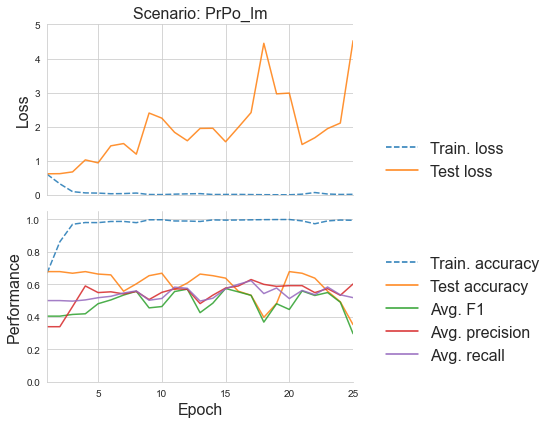

In [10]:
result_prpo_im = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h336-14-Feb-2022-14-41-22-px.csv"
plotCNNPerformanceMetrics(result_prpo_im, scenario="PrPo_Im")

### 6-layer architecture, test set size=0.3, occlusion=0.3, pixel_level=True

summary
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.602238,0.676311,0.649390,0.632911,0.387597,0.500000,0.316456,PrPo_Im,1
1,1,0.332388,0.866787,0.832240,0.632911,0.387597,0.500000,0.316456,PrPo_Im,2
2,2,0.124118,0.958409,0.739799,0.628692,0.406556,0.501494,0.516810,PrPo_Im,3
3,3,0.039048,0.991260,0.862631,0.632911,0.494546,0.531379,0.574645,PrPo_Im,4
4,4,0.029142,0.990958,2.691457,0.637131,0.399965,0.505747,0.817797,PrPo_Im,5
5,5,0.026416,0.992465,1.322581,0.594937,0.581149,0.588276,0.582818,PrPo_Im,6
6,6,0.057014,0.977095,2.886793,0.421941,0.392706,0.516782,0.530976,PrPo_Im,7
7,7,0.049742,0.982218,1.755309,0.616034,0.489478,0.520460,0.540701,PrPo_Im,8
8,8,0.030119,0.989753,1.801108,0.586498,0.573741,0.581609,0.576333,PrPo_Im,9
9,9,0.023097,0.992767,1.902154,0.599156,0.563197,0.562644,0.564319,PrPo_Im,10


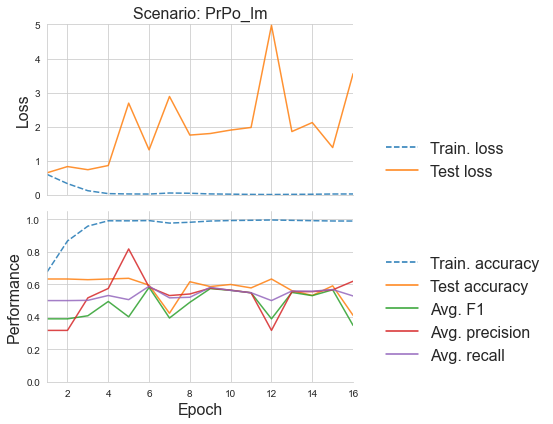

In [11]:
result_prpo_im = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h336-15-Feb-2022-00-54-38-px.csv"
plotCNNPerformanceMetrics(result_prpo_im, scenario="PrPo_Im")

### 5-layer architecture, test set size=0.3, occlusion=0.3, pixel_level=True

summary
base model ylimit set


,Unnamed: 0,loss,accuracy,val_loss,val_accuracy,val_f1,val_recall,val_precision,Scenario,epoch
0,0,0.623927,0.656721,0.651667,0.632911,0.387597,0.500000,0.316456,PrPo_Im,1
1,1,0.367713,0.838457,0.638534,0.624473,0.384416,0.493333,0.314894,PrPo_Im,2
2,2,0.136376,0.953285,1.144891,0.632911,0.387597,0.500000,0.316456,PrPo_Im,3
3,3,0.057084,0.982821,0.711244,0.611814,0.594480,0.599195,0.594241,PrPo_Im,4
4,4,0.045658,0.984629,0.971180,0.582278,0.578648,0.600000,0.593535,PrPo_Im,5
5,5,0.028834,0.993068,2.170511,0.485232,0.473755,0.564368,0.587318,PrPo_Im,6
6,6,0.030873,0.989451,1.273293,0.628692,0.605896,0.607701,0.604951,PrPo_Im,7
7,7,0.040092,0.986739,2.960176,0.637131,0.410243,0.508161,0.651709,PrPo_Im,8
8,8,0.063964,0.977697,2.257455,0.645570,0.451389,0.524483,0.655702,PrPo_Im,9
9,9,0.037188,0.986739,1.198383,0.628692,0.573880,0.573908,0.586270,PrPo_Im,10


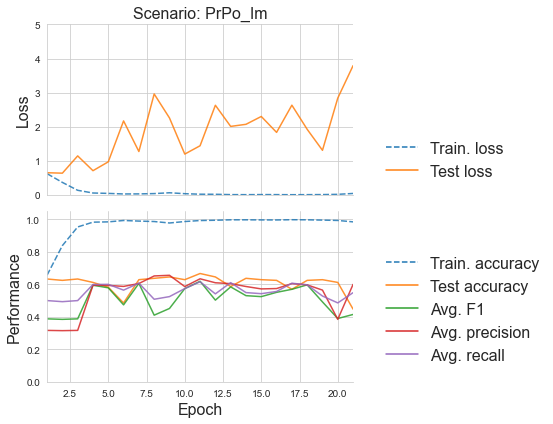

In [12]:
result_prpo_im = "../../results/opt-cnn-performance-metrics-summary-base-w-336-px-h336-15-Feb-2022-03-00-18-px.csv"
plotCNNPerformanceMetrics(result_prpo_im, scenario="PrPo_Im")

### ResNet test set size=0.3, occlusion=0.3, pixel_level=True

### Inception test set size=0.3, occlusion=0.3, pixel_level=True